# Constraint Satisfaction

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

from util import constraint, displayBoard
from sympy import *
from IPython.display import display
init_printing()
%matplotlib inline

## Representing the N-Queens Problem
There are many acceptable ways to represent the N-queens problem, but one convenient way is to recognize that one of the constraints (either the row or column constraint) can be enforced implicitly by the encoding.  If we represent a solution as an array with N elements, then each position in the array can represent a column of the board, and the value at each position can represent which row the queen is placed on.

In this encoding, we only need a constraint to make sure that no two queens occupy the same row, and one to make sure that no two queens occupy the same diagonal.

### Define Symbolic Expressions for the Problem Constraints
Before implementing the board class, we need to construct the symbolic constraints that will be used in the CSP.  Declare any symbolic terms required, and then declare two generic constraint generators:
- `diffRow` - generate constraints that return True if the two arguments do not match
- `diffDiag` - generate constraints that return True if two arguments are not on the same diagonal

In [7]:
# Declare any required symbolic variables
X = symbols('X:2')
Y = symbols('Y:2')

# Define diffRow and diffDiag constraints
diffRow = constraint('DiffRow', Ne(Y[0], Y[1]))
diffDiag = constraint('DiffDiag', Ne(X[0]-X[1], Y[0]-Y[1]))

In [10]:
# Test diffRow and diffDiag
_x = symbols("x:3")

# generate a diffRow instance for testing
diffRow_test = diffRow.subs({Y[0]: _x[0], Y[1]: _x[1]})

assert(len(diffRow_test.free_symbols) == 2)
assert(diffRow_test.subs({_x[0]: 0, _x[1]: 1}) == True)
assert(diffRow_test.subs({_x[0]: 0, _x[1]: 0}) == False)
assert(diffRow_test.subs({_x[0]: 0}) != False)  # partial assignment is not false
print("Passed all diffRow tests.")

# generate a diffDiag instance for testing
diffDiag_test = diffDiag.subs({Y[0]: _x[0], Y[1]: 2, X[0]: 0, X[1]: _x[2]})

assert(len(diffDiag_test.free_symbols) == 2)
assert(diffDiag_test.subs({_x[0]: 0, _x[2]: 2}) == False)
assert(diffDiag_test.subs({_x[0]: 0, _x[2]: 0}) == True)
assert(diffDiag_test.subs({_x[0]: 0}) != False)  # partial assignment is not false
print("Passed all diffDiag tests.")

Passed all diffRow tests.
Passed all diffDiag tests.


### The N-Queens CSP Class
Implement the CSP class as described above, with constraints to make sure each queen is on a different row and different diagonal than every other queen, and a variable for each column defining the row that containing a queen in that column.

In [11]:
class NQueensCSP:
    """CSP representation of the N-queens problem
    
    Parameters
    ----------
    N : Integer
        The side length of a square chess board to use for the problem, and
        the number of queens that must be placed on the board
    """
    def __init__(self, N):
        _vars = symbols('j:%s'%(N))
        _domain = set(range(N))
        self.size = N
        self.variables = _vars
        self.domains = {v: _domain for v in _vars}
        self._constraints = {x: set() for x in _vars}

        # add constraints - for each pair of variables xi and xj, create
        # a diffRow(xi, xj) and a diffDiag(xi, xj) instance, and add them
        # to the self._constraints dictionary keyed to both xi and xj;
        for i,s in enumerate(_vars):
            self._constraints[s].add(diffDiag)
            self._constraints[s].add(diffRow) 
        
    @property
    def constraints(self):
        """Read-only list of constraints -- cannot be used for evaluation """
        constraints = set()
        for _cons in self._constraints.values():
            constraints |= _cons
        return list(constraints)
    
    def is_complete(self, assignment):
        """An assignment is complete if it is consistent, and all constraints
        are satisfied.
        
        Parameters
        ----------
        assignment : dict(sympy.Symbol: Integer)
            An assignment of values to variables that have previously been checked
            for consistency with the CSP constraints
        """
        if len(assignment.keys()) == self.size:
            complete=True
            for k_1,v_1 in assignment.items():
                complete = self.is_consistent(k_1,v_1,assignment)
                if not complete:
                    return False
            return complete
        else:
            return False
        
    def is_consistent(self, var, value, assignment):
        """Check consistency of a proposed variable assignment
                
        self._constraints[x] returns a set of constraints that involve variable `x`.
        An assignment is consistent unless the assignment it causes a constraint to
        return False (partial assignments are always consistent).
        
        Parameters
        ----------
        var : sympy.Symbol
            One of the symbolic variables in the CSP
            
        value : Numeric
            A valid value (i.e., in the domain of) the variable `var` for assignment

        assignment : dict(sympy.Symbol: Integer)
            A dictionary mapping CSP variables to row assignment of each queen
            
        """
        locations = [(i, j, assignment[j]) for i, j in enumerate(self.variables)
                     if assignment.get(j, None) is not None and j !=var ]

        s_row, diag = tuple(self._constraints[var])
        x_1 = self.variables.index(var)
        
        
        for loc in locations:
            x,y,val = loc
            const_1 = diag.subs({Y[0]:value, X[0]:x_1, Y[1]:val,  X[1]:x })
            const_2 = s_row.subs({Y[0]:value, X[0]:x_1, Y[1]:val,  X[1]:x })
            if  const_1 == False:
                return False 
            if const_2==False or (value-val) == -(x_1-x):
                return False
        return True        
        
    def inference(self, var, value):
        """Perform logical inference based on proposed variable assignment
        
        Returns an empty dictionary by default; function can be overridden to
        check arc-, path-, or k-consistency; returning None signals "failure".
        
        Parameters
        ----------
        var : sympy.Symbol
            One of the symbolic variables in the CSP
        
        value : Integer
            A valid value (i.e., in the domain of) the variable `var` for assignment
            
        Returns
        -------
        dict(sympy.Symbol: Integer) or None
            A partial set of values mapped to variables in the CSP based on inferred
            constraints from previous mappings, or None to indicate failure
        """
        # TODO: Implement this function based on AIMA discussion
        return {}
    
    def show(self, assignment):
        """Display a chessboard with queens drawn in the locations specified by an
        assignment
        
        Parameters
        ----------
        assignment : dict(sympy.Symbol: Integer)
            A dictionary mapping CSP variables to row assignment of each queen
            
        """
        locations = [(i, assignment[j]) for i, j in enumerate(self.variables)
                     if assignment.get(j, None) is not None]
        displayBoard(locations, self.size)

## Backtracking Search
Implement the [backtracking search](https://github.com/aimacode/aima-pseudocode/blob/master/md/Backtracking-Search.md) algorithm and helper functions from the AIMA text.  

In [12]:
def select(csp, assignment):
    """Choose an unassigned variable in a constraint satisfaction problem """
    # TODO: Implement a more sophisticated selection routine from AIMA
    for var in csp.variables:
        if var not in assignment:
            return var
    return None

def order_values(var, assignment, csp):
    """Select the order of the values in the domain of a variable for checking during search;
    the default is lexicographically.
    """
    # TODO: Implement a more sophisticated search ordering routine from AIMA
    return csp.domains[var]

def backtracking_search(csp):
    """Helper function used to initiate backtracking search """
    return backtrack({}, csp)

def backtrack(assignment, csp):
    """Perform backtracking search for a valid assignment to a CSP
    
    Parameters
    ----------
    assignment : dict(sympy.Symbol: Integer)
        An partial set of values mapped to variables in the CSP
        
    csp : CSP
        A problem encoded as a CSP. Interface should include csp.variables, csp.domains,
        csp.inference(), csp.is_consistent(), and csp.is_complete().
    
    Returns
    -------
    dict(sympy.Symbol: Integer) or None
        A partial set of values mapped to variables in the CSP, or None to indicate failure
    """
    if csp.is_complete(assignment):
        return assignment
    var = select(csp,assignment)
    for value in  csp.domains[var]:
        ass_copy = { k:v for k,v in assignment.items()}
        ass_copy[var] = value
        if csp.is_consistent( var, value, assignment ):
            assignment[var] = value
            result = backtrack(assignment,csp)
            if result:
                return result
        elif assignment.get(var,None) !=None:
            assignment.pop(var)

### Solve the CSP

CSP problems have variables, each variable has a domain, and the problem has a list of constraints.
Showing the variables for the N-Queens CSP:


Showing domain for j0:


And showing the constraints for j0:


Solving N-Queens CSP...


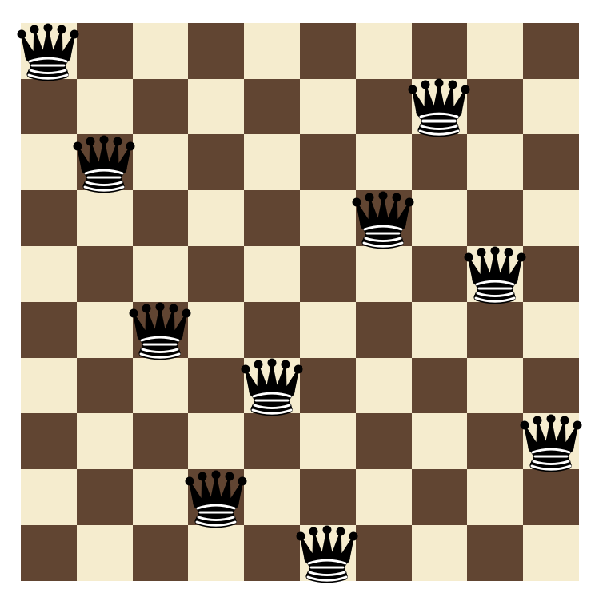

Solution found:
{j1: 2, j2: 5, j3: 8, j9: 7, j6: 3, j8: 4, j5: 9, j7: 1, j4: 6, j0: 0}


In [14]:
num_queens = 10
csp = NQueensCSP(num_queens)
var = csp.variables[0]
print("CSP problems have variables, each variable has a domain, and the problem has a list of constraints.")
print("Showing the variables for the N-Queens CSP:")
display(csp.variables)
print("Showing domain for {}:".format(var))
display(csp.domains[var])
print("And showing the constraints for {}:".format(var))
display(csp._constraints[var])

print("Solving N-Queens CSP...")
assn = backtracking_search(csp)
if assn is not None:
    csp.show(assn)
    print("Solution found:\n{!s}".format(assn))
else:
    print("No solution found.")

## Experiments

- Implement a _bad_ N-queens solver: generate & test candidate solutions one at a time until a valid solution is found.  For example, represent the board as an array with $N^2$ elements, and let each element be True if there is a queen in that box, and False if it is empty.  Use an $N^2$-bit counter to generate solutions, then write a function to check if each solution is valid.  Notice that this solution doesn't require any of the techniques we've applied to other problems -- there is no DFS or backtracking, nor constraint propagation, or even explicitly defined variables.

- Use more complex constraints -- i.e., generalize the binary constraint RowDiff to an N-ary constraint AllRowsDiff, etc., -- and solve the problem again.

- Rewrite the CSP class to use forward checking to restrict the domain of each variable as new values are assigned.

- The sympy library isn't very fast, so this version of the CSP doesn't work well on boards bigger than about 12x12.  Write a new representation of the problem class that uses constraint functions (like the Sudoku project) to implicitly track constraint satisfaction through the restricted domain of each variable.  How much larger can you solve?